# 实战TensorFlow房价预测

### 目录

 房价预测模型介绍

 使用TensorFlow实现房价预测模型

 使用TensorBoard可视化模型数据流图


### 一、房价预测模型介绍

### 1.前置知识

<img src="./imgs/1.jpg" width=650>

<img src="./imgs/2.jpg" width=650>

<img src="./imgs/3.jpg" width=650>

### 2.单变量房价预测问题

###### 问题描述：
根据房屋面积x来预测其销售价格y

In [1]:
# 导包
# pandas是一个BSD开源协议许可的，面向python用户的高性能和易于上手的数据结构化和数据分析工具
# seaborn是一个基于matplotlib的python数据可视化库，它提供了更易用的高级接口，而且有易于绘制精美且信息丰富的统计图像
import pandas as pd
import seaborn as sns
sns.set(context="notebook",style="whitegrid",palette="dark")

In [2]:
# 查看q前5行数据
df0 = pd.read_csv("data/data0.csv",names=["square","price"])
df0.head()

,square,price
0,2104,399900
1,1600,329900
2,2400,369000
3,1416,232000
4,3000,539900


D:\software\Anaconda\workplace\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


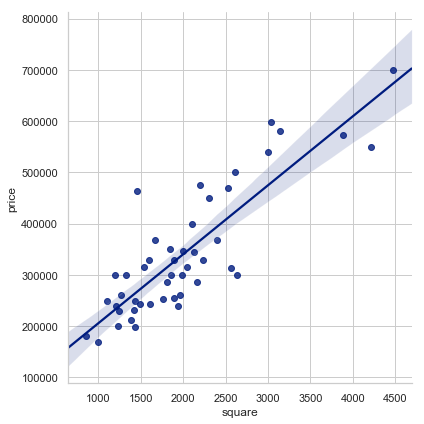

In [3]:
# 绘图来表示数据
# seaborn.lmplot()方法专门用于用于线性关系的可视化，适用于回归模型
sns.lmplot("square","price",df0,height=6,fit_reg=True)

In [4]:
# 查看数据的详细信息
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 2 columns):
square    47 non-null int64
price     47 non-null int64
dtypes: int64(2)
memory usage: 832.0 bytes


### 3. 多变量房价预测

###### a.问题描述：
根据房屋面积x1和卧室面积数量x2，预测其销售价格y

###### b.查看数据

In [5]:
# 导包
# matplotlib是一个Python 2D绘图库
# mpl_toolkits.mplot3d是一个基础3d绘图（散点图、平面图、折线图）工具集，也是matplotlib库的一部分
import matplotlib.pyplot as plt

from mpl_toolkits import mplot3d

In [6]:
# 读取数据，显示前5行数据
df1 = pd.read_csv("data/data1.csv",names=["square","bedrooms","price"])
df1.head()

,square,bedrooms,price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


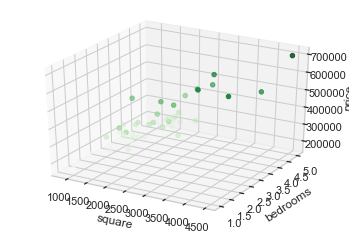

In [7]:
# 绘制3D散点图
fig = plt.figure()
# 创建一个Axes3D object
ax = plt.axes(projection="3d")
# 设置三个坐标的名称
ax.set_xlabel("square")
ax.set_ylabel("bedrooms")
ax.set_zlabel("price")
# 绘制3D散点图
ax.scatter3D(df1["square"],df1["bedrooms"],df1["price"],c=df1["price"],cmap="Greens")

###### c.数据归一化处理

然而房屋面积和卧室数量这两个变量（特征）在数值上差了1000倍。在这种情况下，通常先进行特征缩放，再开始训练，可以加速模型收敛。

<img src="./imgs/5.jpg">

In [8]:
# 定义归一化函数
def normalize_feature(df):
    return df.apply(lambda column:(column-column.mean()) / column.std())


In [9]:
# 重新查看数据
df = normalize_feature(df1)
df.head()

,square,bedrooms,price
0,0.130010,-0.223675,0.475747
1,-0.504190,-0.223675,-0.084074
2,0.502476,-0.223675,0.228626
3,-0.735723,-1.537767,-0.867025
4,1.257476,1.090417,1.595389


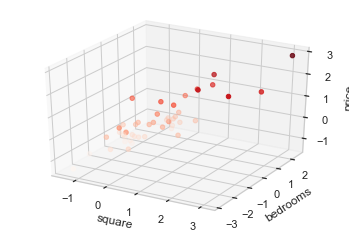

In [10]:
# 重新展示数据
ax = plt.axes(projection="3d")
ax.set_xlabel("square")
ax.set_ylabel("bedrooms")
ax.set_zlabel("price")
ax.scatter3D(df["square"],df["bedrooms"],df["price"],c=df["price"],cmap="Reds")

In [11]:
# 查看数据详细信息
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 3 columns):
square      47 non-null float64
bedrooms    47 non-null float64
price       47 non-null float64
dtypes: float64(3)
memory usage: 1.2 KB


###### d.数据处理：添加ones列(x0)

In [12]:
# numpy 是bsd开源协议许可的，面向python用户的基础科学计算库，在多维数组上实现了线性代数、傅里叶变换和其它丰富的函数运算
# 生成一列ones,ones是n行1列的数据框，表示x0恒为1
import numpy as np
ones = pd.DataFrame({"ones":np.ones(len(df))})

In [13]:
# 根据列合并数据
df = pd.concat([ones,df],axis=1)
df.head()

,ones,square,bedrooms,price
0,1.0,0.130010,-0.223675,0.475747
1,1.0,-0.504190,-0.223675,-0.084074
2,1.0,0.502476,-0.223675,0.228626
3,1.0,-0.735723,-1.537767,-0.867025
4,1.0,1.257476,1.090417,1.595389


In [14]:
# 查看详细数据
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 4 columns):
ones        47 non-null float64
square      47 non-null float64
bedrooms    47 non-null float64
price       47 non-null float64
dtypes: float64(4)
memory usage: 1.5 KB


### 二、使用TensorFlow实现房价预测模型

<img src="./imgs/6.jpg" width=600>

###### 1.前期数据处理

In [15]:
import pandas as pd
import numpy as np

# 定义标准化的函数
def normalize_feature(df):
    return df.apply(lambda column:(column-column.mean())/column.std())

df = normalize_feature(pd.read_csv("./data/data1.csv",names=["square","bedrooms","price"]))
ones = pd.DataFrame({"ones": np.ones(len(df))})

df = pd.concat([ones,df],axis=1)
df.head()


,ones,square,bedrooms,price
0,1.0,0.130010,-0.223675,0.475747
1,1.0,-0.504190,-0.223675,-0.084074
2,1.0,0.502476,-0.223675,0.228626
3,1.0,-0.735723,-1.537767,-0.867025
4,1.0,1.257476,1.090417,1.595389


### 2.获取数据

In [16]:
X_data = np.array(df[df.columns[0:3]])
y_data = np.array(df[df.columns[-1]]).reshape(len(df),1)

print(X_data.shape,type(X_data))
print(y_data.shape,type(y_data))

(47, 3) <class 'numpy.ndarray'>
(47, 1) <class 'numpy.ndarray'>


### 3.创建线性回归模型

In [17]:
import tensorflow as tf

alpha = 0.01 # 学习率 alpha
epoch = 500 # 训练全量数据集的轮数

with tf.name_scope('input'):
    # 输入 X，形状[47, 3]
    X = tf.placeholder(tf.float32, X_data.shape, name='X')
    # 输出 y，形状[47, 1]
    y = tf.placeholder(tf.float32, y_data.shape, name='y')

with tf.name_scope('hypothesis'):
    # 权重变量 W，形状[3,1]
    W = tf.get_variable("weights",
                        (X_data.shape[1], 1),
                        initializer=tf.constant_initializer())
    # 假设函数 h(x) = w0*x0+w1*x1+w2*x2, 其中x0恒为1
    # 推理值 y_pred  形状[47,1]
    y_pred = tf.matmul(X, W, name='y_pred')

with tf.name_scope('loss'):
    # 损失函数采用最小二乘法，y_pred - y 是形如[47, 1]的向量。
    # tf.matmul(a,b,transpose_a=True) 表示：矩阵a的转置乘矩阵b，即 [1,47] X [47,1]
    # 损失函数操作 loss
    loss_op = 1 / (2 * len(X_data)) * tf.matmul((y_pred - y), (y_pred - y), transpose_a=True)
with tf.name_scope('train'):
    # 随机梯度下降优化器 opt
    train_op = tf.train.GradientDescentOptimizer(learning_rate=alpha).minimize(loss_op)

Instructions for updating:
Colocations handled automatically by placer.


### 4.创建会话

In [18]:
with tf.Session() as sess:
    # 初始化全局变量
    sess.run(tf.global_variables_initializer())
    # 创建FileWriter实例，并传入当前会话加载的数据流图
    writer = tf.summary.FileWriter('./summary/linear-regression-1', sess.graph)
    # 记录所有损失值
    loss_data = []
    # 开始训练模型
    # 因为训练集较小，所以采用批梯度下降优化算法，每次都使用全量数据训练
    for e in range(1, epoch + 1):
        _, loss, w = sess.run([train_op, loss_op, W], feed_dict={X: X_data, y: y_data})
        # 记录每一轮损失值变化情况
        loss_data.append(float(loss))
        if e % 10 == 0:
            log_str = "Epoch %d \t Loss=%.4g \t Model: y = %.4gx1 + %.4gx2 + %.4g"
            print(log_str % (e, loss, w[1], w[2], w[0]))

# 关闭FileWriter的输出流
writer.close()            

Epoch 10 	 Loss=0.4184 	 Model: y = 0.0791x1 + 0.03948x2 + 3.353e-10
Epoch 20 	 Loss=0.3582 	 Model: y = 0.1489x1 + 0.07135x2 + -5.588e-11
Epoch 30 	 Loss=0.3126 	 Model: y = 0.2107x1 + 0.09676x2 + 3.912e-10
Epoch 40 	 Loss=0.2778 	 Model: y = 0.2655x1 + 0.1167x2 + -1.863e-11
Epoch 50 	 Loss=0.2512 	 Model: y = 0.3142x1 + 0.1321x2 + 1.77e-10
Epoch 60 	 Loss=0.2306 	 Model: y = 0.3576x1 + 0.1436x2 + -4.47e-10
Epoch 70 	 Loss=0.2145 	 Model: y = 0.3965x1 + 0.1519x2 + -8.941e-10
Epoch 80 	 Loss=0.2018 	 Model: y = 0.4313x1 + 0.1574x2 + -6.24e-10
Epoch 90 	 Loss=0.1917 	 Model: y = 0.4626x1 + 0.1607x2 + -4.191e-10
Epoch 100 	 Loss=0.1835 	 Model: y = 0.4909x1 + 0.1621x2 + -5.402e-10
Epoch 110 	 Loss=0.1769 	 Model: y = 0.5165x1 + 0.162x2 + -7.125e-10
Epoch 120 	 Loss=0.1714 	 Model: y = 0.5397x1 + 0.1606x2 + -5.076e-10
Epoch 130 	 Loss=0.1668 	 Model: y = 0.5609x1 + 0.1581x2 + -8.335e-10
Epoch 140 	 Loss=0.1629 	 Model: y = 0.5802x1 + 0.1549x2 + -9.22e-10
Epoch 150 	 Loss=0.1596 	 Model: y

##### 估计模型：y = 0.8304x1 + 0.0008239x2 + 4.303e-09

### 三、使用TensorBoard可视化模型数据流图

###### 1.TensorBoard使用流程

<img src="./imgs/7.jpg" width=650>

###### 2.可视化数据流图--工作流

<img src="./imgs/8.jpg " width=650>

### 3.可视化数据流图制作

###### a.TensorBoard查看数据流图

<img src="./imgs/10.jpg" width=650>


<img src="./imgs/11.jpg" width=650>

###### b.可视化损失值


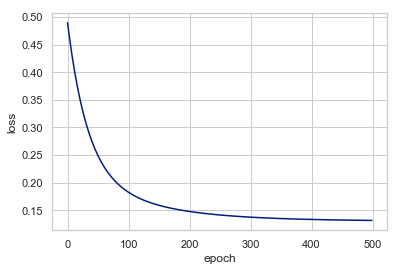

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="notebook", style="whitegrid", palette="dark")

ax = sns.lineplot(x='epoch', y='loss', data=pd.DataFrame({'loss': loss_data, 'epoch': np.arange(epoch)}))
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.show()